In [ ]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# read excel file
df = pd.read_excel('C1Data.xlsx', sheet_name=None)

# name the sheets
bonds = df['Bonds']
yield_curve = df['YieldCurve']

# change columns to datetime
bonds['OFFERING_DATE'] = pd.to_datetime(bonds['OFFERING_DATE'])
bonds['MATURITY'] = pd.to_datetime(bonds['MATURITY'])
bonds['TRD_EXCTN_DT'] = pd.to_datetime(bonds['TRD_EXCTN_DT'])

#find the ones where the trade date is after the maturity date and remove them
bonds = bonds[bonds['TRD_EXCTN_DT'] < bonds['MATURITY']]

# get rid of the row where the principal amount is 1
bonds = bonds[~(bonds['PRINCIPAL_AMT'] == 1)]

# drop na in the yield_curve data
yield_curve.dropna(inplace=True)

# change the column names
yield_curve.columns = ['Date', '2024_data', '2025_data']

# make regex that only gets numbers and apply to the Date column
yield_curve['Date'] = yield_curve['Date'].apply(lambda x: re.findall(r'\d+', x)[0])

# change date column to numeric
yield_curve['Date'] = pd.to_numeric(yield_curve['Date'])/100

# change the data columns to numeric
yield_curve['2024_data'] = pd.to_numeric(yield_curve['2024_data'])
yield_curve['2025_data'] = pd.to_numeric(yield_curve['2025_data'])



Text(0, 0.5, 'Yield')

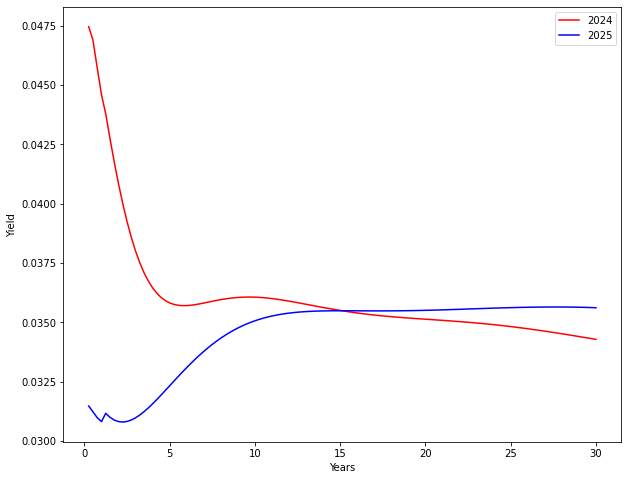

In [ ]:
# plot the yield curve
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')

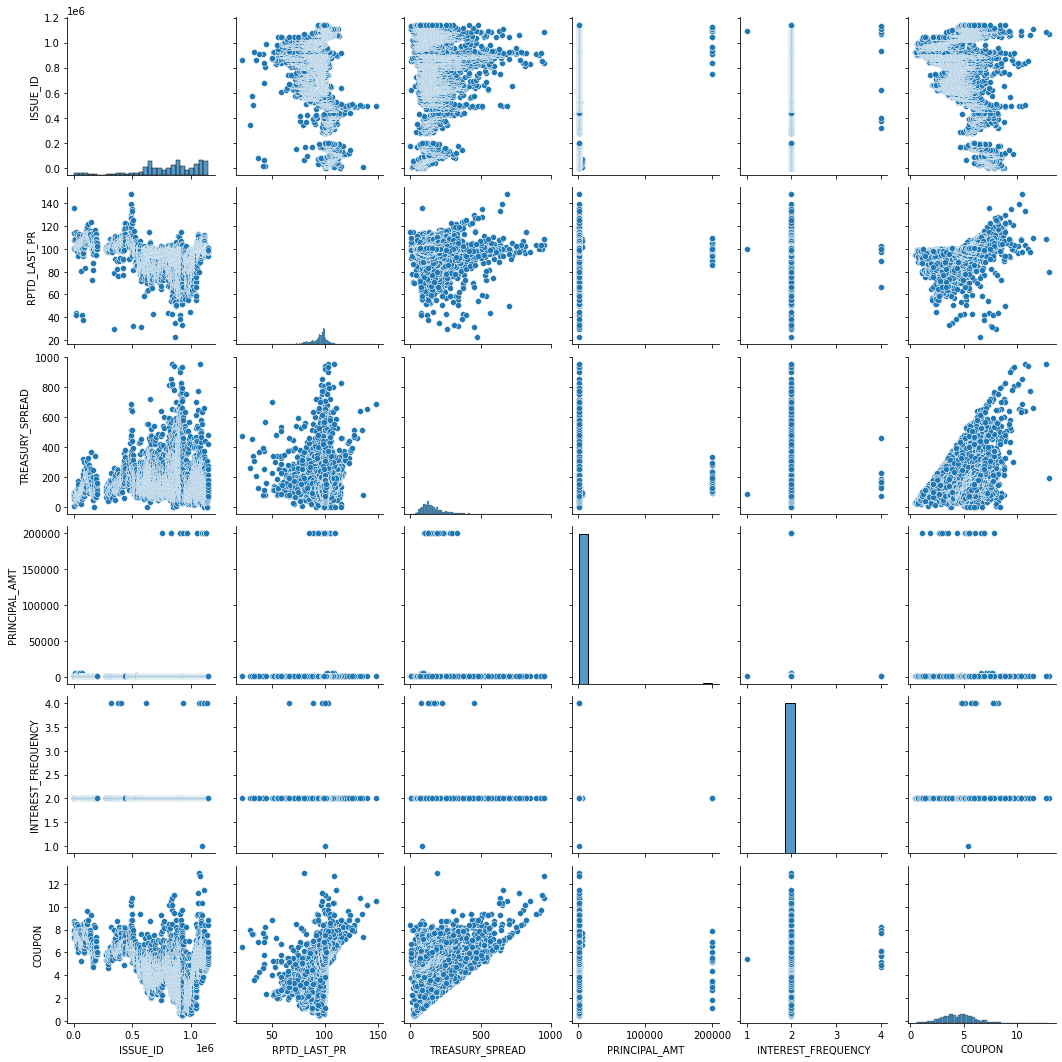

In [63]:
# make pairplot of bonds data
sns.pairplot(bonds)

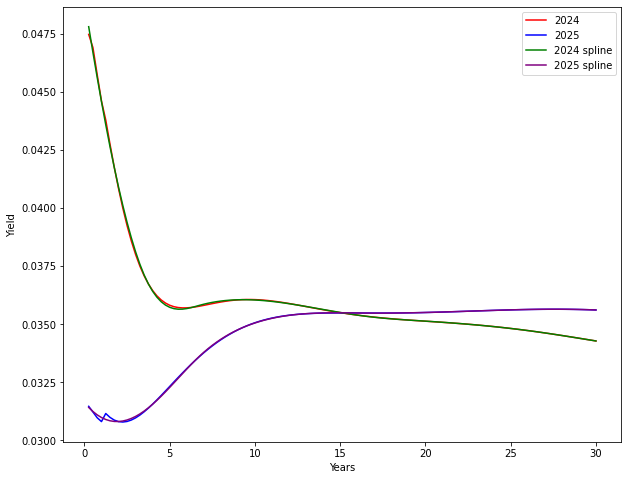

In [ ]:
# make model for splines

from scipy.interpolate import LSQUnivariateSpline
import numpy as np
import matplotlib.pyplot as plt

# Define the positions of the knots (excluding the endpoints)
knots = np.linspace(yield_curve['Date'].min(), yield_curve['Date'].max(), 10)[1:-1]

# make the spline with specified knots
spline_2024 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2024_data'], t=knots, k=3)
spline_2025 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2025_data'], t=knots, k=3)

# make the plot
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.plot(yield_curve['Date'], spline_2024(yield_curve['Date']), label='2024 spline', color='green')
plt.plot(yield_curve['Date'], spline_2025(yield_curve['Date']), label='2025 spline', color='purple')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.show()

In [59]:
bonds.head()

,ISSUE_ID,TRD_EXCTN_DT,RPTD_LAST_PR,MATURITY,TREASURY_SPREAD,OFFERING_DATE,PRINCIPAL_AMT,INTEREST_FREQUENCY,COUPON,RATING,SECURITY_LEVEL
0,2560,2024-05-31,114.375,2031-09-15,80.0,1991-09-10,1000,2,8.750,BBB,SEN
1,2562,2024-05-31,113.800,2031-11-15,85.0,1991-11-08,1000,2,8.625,BBB,SEN
2,2563,2024-05-31,100.301,2024-08-15,50.0,1992-08-06,1000,2,7.950,BBB,SEN
3,2564,2024-05-31,114.080,2043-04-15,100.0,1993-04-06,1000,2,7.875,BBB,SEN
4,2566,2024-05-31,100.915,2025-06-15,69.0,1993-06-29,1000,2,7.250,BBB,SEN


In [ ]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# given a date and a list of cash flow dates, find the number of years to the previous cash flow date
def years_to_previous_date(date, cash_flow_dates):

    days_to_previous = [(date - cash_flow_date).days for cash_flow_date in cash_flow_dates]

    return -max(days_to_previous)/365

def cashflow_dates(start_date, end_date, frequency):
    dates = []
    current_date = start_date

    while current_date > end_date:
        dates.append(current_date.date())
        current_date -= relativedelta(months=12/frequency)

    return dates


np.arange(30, 0, -1)


# given a bond with its maturity date, coupon frequency, issue date and interest rate and principal amount make a df of all the cash flows and the number of years away each one is
def cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate):

    cash_flow_dates = cashflow_dates(maturity_date, offering_date, frequency)
    
    # remove all cash flows that are before today
    cash_flow_dates = [date for date in cash_flow_dates if date > today]

    # find the years to the next coupon date
    years_to_next_coupon = years_to_previous_date(today, cash_flow_dates)

    # get the years to maturity of each cash flow, the first one is the number of days from today until the next coupon then each coupon is 12/frequency more
    years = np.arange(len(cash_flow_dates) - 1, -1, -1) * 1/frequency + years_to_next_coupon

    # combine cash flow dates and years into a df
    cash_flows = pd.DataFrame({'Date': cash_flow_dates, 'Years': years})

    # add cashflow amounts
    cash_flows['Amount'] = principal * interest_rate/frequency

    # add the principal to the first cashflow
    cash_flows.loc[cash_flows.index[0], 'Amount'] += principal

    return cash_flows

cashflows = cashflows_and_years(bonds['OFFERING_DATE'][1],bonds['MATURITY'][1], 2, datetime.now().date(), bonds['PRINCIPAL_AMT'][1], bonds['COUPON'][1]/100)

# make a function that given the cashflows and the spline model of the yields discounts each one to the present value
def present_value(cash_flows, spline, spread=0):
    cash_flows['Discounted'] = cash_flows['Amount']/((1 + spline(cash_flows['Years']) + spread)**cash_flows['Years'])

    return sum(cash_flows['Discounted'])

present_value(cashflows, spline_2024, 0.06)

# make a function that combines everything

def bond_value(offering_date, maturity_date, frequency, today, principal, interest_rate, spline, spread):

    cashflows = cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate)
    
    return present_value(cashflows, spline, spread)

# set today to 2024-05-31
today = datetime(2024, 5, 31).date()

# apply the bond_value function to the bonds df
bonds['Value'] = bonds.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  today, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2024, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)


d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
d
